cut_date - дата на которую считаются статистики

days_to_end - кол-во дней до конца подписки

first_date - дата первого появления на сервисе

last_date - дата последнего появления на сервисе

num_country_max_1days - максимальное кол-во стран, в которых был пользователь за период 1 день

other_content_sum_30days - сумма по кол-ву просмотров контента не из top10 за период 30 дней

num_title_ep_sum_3days - сумма по кол-ву просмотренных серий за период в 3 дня

top_10_sum_30days - сумма по кол-ву просмотров сериала (именно top 10) за период …

pc_max_30days - максимаьлное кол-во раз когда использовался компьютер за период …

activity_1to3 - активность за период с 3 до 1 дней 

Все периоды считаются на cut_date по сути

title_ep и title_ru — по ним считаются разные агрегации в подготовленных данных. - да это различные заголовки серий или сериала

utc_offset — это часовой пояс? - не совсем это смещение часового пояса

dt1 - timestamp по пользователю, условно в этот момент мы этого пользователя увидели, calday как раз считается от dt1

Как считался calday в raw-data и в additional — они отличаются. - они отличаются, из-за того что additional взят из другого источника

timelength — продолжительность использования сервисом? - да

In [0]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_recall_curve, confusion_matrix, average_precision_score
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score
import lightgbm as lgbm
import datetime
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
%matplotlib inline

In [3]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 1000)

In [0]:
train_prep = pd.read_csv('/content/gdrive/My Drive/test_task/umatech/TRAIN_PREPARED.csv')
test_prep = pd.read_csv('/content/gdrive/My Drive/test_task/umatech/TEST_PREPARED.csv')
train_add = pd.read_csv('/content/gdrive/My Drive/test_task/umatech/TRAIN_ADDITIONAL_DATA.csv')
test_add = pd.read_csv('/content/gdrive/My Drive/test_task/umatech/TEST_ADDITIONAL_DATA.csv')
train_raw = pd.read_csv('/content/gdrive/My Drive/test_task/umatech/TRAIN_RAW_DATA.csv')
test_raw = pd.read_csv('/content/gdrive/My Drive/test_task/umatech/TEST_RAW_DATA.csv')

In [6]:
train_prep.head(2)

,cut_date,days_to_end,email,first_date,last_date,num_country_max_1days,num_city_max_1days,android_max_1days,smarttv_max_1days,iphone_max_1days,ipad_max_1days,apple_max_1days,pc_max_1days,time_spent_sum_3days,time_spent_max_3days,num_title_ep_sum_3days,num_title_ep_max_3days,num_title_ru_sum_3days,num_title_ru_max_3days,num_country_max_3days,num_city_max_3days,other_content_sum_3days,top_1_sum_3days,top_2_sum_3days,top_3_sum_3days,top_4_sum_3days,top_5_sum_3days,top_6_sum_3days,top_7_sum_3days,top_8_sum_3days,top_9_sum_3days,top_10_sum_3days,android_max_3days,smarttv_max_3days,iphone_max_3days,ipad_max_3days,apple_max_3days,pc_max_3days,time_spent_sum_7days,time_spent_max_7days,num_title_ep_sum_7days,num_title_ep_max_7days,num_title_ru_sum_7days,num_title_ru_max_7days,num_country_max_7days,num_city_max_7days,other_content_sum_7days,top_1_sum_7days,top_2_sum_7days,top_3_sum_7days,top_4_sum_7days,top_5_sum_7days,top_6_sum_7days,top_7_sum_7days,top_8_sum_7days,top_9_sum_7days,top_10_sum_7days,android_max_7days,smarttv_max_7days,iphone_max_7days,ipad_max_7days,apple_max_7days,pc_max_7days,time_spent_sum_14days,time_spent_max_14days,num_title_ep_sum_14days,num_title_ep_max_14days,num_title_ru_sum_14days,num_title_ru_max_14days,num_country_max_14days,num_city_max_14days,other_content_sum_14days,top_1_sum_14days,top_2_sum_14days,top_3_sum_14days,top_4_sum_14days,top_5_sum_14days,top_6_sum_14days,top_7_sum_14days,top_8_sum_14days,top_9_sum_14days,top_10_sum_14days,android_max_14days,smarttv_max_14days,iphone_max_14days,ipad_max_14days,apple_max_14days,pc_max_14days,time_spent_sum_21days,time_spent_max_21days,num_title_ep_sum_21days,num_title_ep_max_21days,num_title_ru_sum_21days,num_title_ru_max_21days,num_country_max_21days,num_city_max_21days,other_content_sum_21days,top_1_sum_21days,top_2_sum_21days,top_3_sum_21days,top_4_sum_21days,top_5_sum_21days,top_6_sum_21days,top_7_sum_21days,top_8_sum_21days,top_9_sum_21days,top_10_sum_21days,android_max_21days,smarttv_max_21days,iphone_max_21days,ipad_max_21days,apple_max_21days,pc_max_21days,time_spent_sum_30days,time_spent_max_30days,num_title_ep_sum_30days,num_title_ep_max_30days,num_title_ru_sum_30days,num_title_ru_max_30days,num_country_max_30days,num_city_max_30days,other_content_sum_30days,top_1_sum_30days,top_2_sum_30days,top_3_sum_30days,top_4_sum_30days,top_5_sum_30days,top_6_sum_30days,top_7_sum_30days,top_8_sum_30days,top_9_sum_30days,top_10_sum_30days,android_max_30days,smarttv_max_30days,iphone_max_30days,ipad_max_30days,apple_max_30days,pc_max_30days,activity_1to3,activity_1to7,activity_1to14,activity_7to14,activity_7to21,activity_7to30,activity_14to30,label
0,2019-04-02 00:00:00,11,8ba752f2c5,2019-02-10 00:00:00,2019-03-13 09:36:59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4367.0,4367.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,59073.0,25595.0,10.0,4.0,10.0,4.0,1.0,20.0,6.0,17.0,20.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.000000,0.0
1,2019-04-02 00:00:00,10,752a6d96f7,2018-10-28 00:00:00,2019-04-01 20:51:29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60.0,60.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,60.0,60.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10332.0,10152.0,12.0,9.0,5.0,2.0,1.0,11.0,0.0,0.0,1.0,9.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,1.0,10392.0,10152.0,13.0,9.0,6.0,2.0,1.0,11.0,0.0,0.0,2.0,9.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,1.0,19801.0,10152.0,22.0,9.0,10.0,3.0,1.0,11.0,1.0,2.0,10.0,9.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,0.0,0.0,4.0,0.0,0.0,0.0,0.005

In [7]:
train_add.head(2)

,action,email,trial,calday
0,DELETE,9007366702,NaN,2018-10-26 03:26:41.607
1,CREATE,ad49ae7b1d,False,2018-12-01 18:16:56.971


In [8]:
train_raw.head(2)

,email,title_ep,title_ru,calday,dt1,timelength,device,country_iso_code,city_iso_code,utc_offset
0,513ed17481,1821f1a1ce58,f1bcc7a5177e,2019-03-04 00:00:00,2019-03-04 17:14:48,45,PC,RU,MOW,3.0
1,0160e02b90,c724f041dc39,a714d9f17666,2019-03-04 00:00:00,2019-03-04 23:23:19,60,AndroidPhone_PlayReady_HW,RU,MOW,3.0


In [0]:
tables = [(train_prep, test_prep), (train_add, test_add), (train_raw, test_raw)]
groups = ['prepared', 'additional', 'raw']

In [10]:
print('Shapes for train - test', end='\n\n')
for name, (train, test) in zip(groups, tables):
    print(name, train.shape, test.shape)

Shapes for train - test

prepared (180249, 146) (10000, 145)
additional (43494, 4) (20462, 4)
raw (1487707, 10) (479161, 10)


In [11]:
print('NaN in train - test', end='\n\n')
for name, (train, test) in zip(groups, tables):
    print(name, train.isnull().sum().sum(), test.isnull().sum().sum())

NaN in train - test

prepared 0 0
additional 199 82
raw 30723 12524


In [12]:
print(train_add.isnull().sum())
print()
print(test_add.isnull().sum())

action      0
email       0
trial     199
calday      0
dtype: int64

action     0
email      0
trial     82
calday     0
dtype: int64


In [13]:
print(train_raw.isnull().sum())
print()
print(test_raw.isnull().sum())

email                   0
title_ep                0
title_ru                0
calday                  0
dt1                     0
timelength              0
device                  0
country_iso_code      648
city_iso_code       29927
utc_offset            148
dtype: int64

email                   0
title_ep                0
title_ru                0
calday                  0
dt1                     0
timelength              0
device                  0
country_iso_code      545
city_iso_code       11924
utc_offset             55
dtype: int64


In [14]:
train_prep.nunique()

cut_date                        21
days_to_end                     15
email                        20000
first_date                     241
last_date                    66794
num_country_max_1days            5
num_city_max_1days              69
android_max_1days               58
smarttv_max_1days               51
iphone_max_1days                50
ipad_max_1days                  41
apple_max_1days                 35
pc_max_1days                    55
time_spent_sum_3days         24903
time_spent_max_3days         15039
num_title_ep_sum_3days          59
num_title_ep_max_3days          40
num_title_ru_sum_3days          18
num_title_ru_max_3days          10
num_country_max_3days            5
num_city_max_3days              72
other_content_sum_3days         64
top_1_sum_3days                130
top_2_sum_3days                 62
top_3_sum_3days                 54
top_4_sum_3days                 56
top_5_sum_3days                 47
top_6_sum_3days                 37
top_7_sum_3days     

In [15]:
test_prep.nunique()

cut_date                        1
days_to_end                    15
email                       10000
first_date                    249
last_date                    9892
num_country_max_1days           3
num_city_max_1days             31
android_max_1days              26
smarttv_max_1days              24
iphone_max_1days               19
ipad_max_1days                 17
apple_max_1days                13
pc_max_1days                   18
time_spent_sum_3days         3441
time_spent_max_3days         3307
num_title_ep_sum_3days         58
num_title_ep_max_3days         36
num_title_ru_sum_3days         12
num_title_ru_max_3days          9
num_country_max_3days           3
num_city_max_3days             41
other_content_sum_3days        57
top_1_sum_3days                40
top_2_sum_3days                22
top_3_sum_3days                16
top_4_sum_3days                22
top_5_sum_3days                15
top_6_sum_3days                21
top_7_sum_3days                20
top_8_sum_3day

In [16]:
train_prep.dtypes

cut_date                     object
days_to_end                   int64
email                        object
first_date                   object
last_date                    object
num_country_max_1days       float64
num_city_max_1days          float64
android_max_1days           float64
smarttv_max_1days           float64
iphone_max_1days            float64
ipad_max_1days              float64
apple_max_1days             float64
pc_max_1days                float64
time_spent_sum_3days        float64
time_spent_max_3days        float64
num_title_ep_sum_3days      float64
num_title_ep_max_3days      float64
num_title_ru_sum_3days      float64
num_title_ru_max_3days      float64
num_country_max_3days       float64
num_city_max_3days          float64
other_content_sum_3days     float64
top_1_sum_3days             float64
top_2_sum_3days             float64
top_3_sum_3days             float64
top_4_sum_3days             float64
top_5_sum_3days             float64
top_6_sum_3days             

In [17]:
test_prep.dtypes

cut_date                     object
days_to_end                   int64
email                        object
first_date                   object
last_date                    object
num_country_max_1days       float64
num_city_max_1days          float64
android_max_1days           float64
smarttv_max_1days           float64
iphone_max_1days            float64
ipad_max_1days              float64
apple_max_1days             float64
pc_max_1days                float64
time_spent_sum_3days        float64
time_spent_max_3days        float64
num_title_ep_sum_3days      float64
num_title_ep_max_3days      float64
num_title_ru_sum_3days      float64
num_title_ru_max_3days      float64
num_country_max_3days       float64
num_city_max_3days          float64
other_content_sum_3days     float64
top_1_sum_3days             float64
top_2_sum_3days             float64
top_3_sum_3days             float64
top_4_sum_3days             float64
top_5_sum_3days             float64
top_6_sum_3days             

In [0]:
for prepared in tables[0]:
    for i in ['cut_date', 'first_date', 'last_date']:
        prepared[i] = pd.to_datetime(prepared[i])

In [20]:
train_prep[['email', 'label']].groupby('email')['label'].mean().value_counts()

0.000000    14443
1.000000     5519
0.500000       10
0.666667        5
0.400000        5
0.750000        5
0.250000        5
0.200000        3
0.333333        2
0.800000        2
0.066667        1
Name: label, dtype: int64

In [0]:
data = train_prep.merge(train_prep[['email', 'label']].groupby('email')['label'].mean(), on='email')
data.label_y.value_counts()
data = data[(data['label_y'] > 0) & (data['label_y'] < 1)].sort_values(by=['email', 'cut_date'])

In [22]:
train_prep.describe()

,days_to_end,num_country_max_1days,num_city_max_1days,android_max_1days,smarttv_max_1days,iphone_max_1days,ipad_max_1days,apple_max_1days,pc_max_1days,time_spent_sum_3days,time_spent_max_3days,num_title_ep_sum_3days,num_title_ep_max_3days,num_title_ru_sum_3days,num_title_ru_max_3days,num_country_max_3days,num_city_max_3days,other_content_sum_3days,top_1_sum_3days,top_2_sum_3days,top_3_sum_3days,top_4_sum_3days,top_5_sum_3days,top_6_sum_3days,top_7_sum_3days,top_8_sum_3days,top_9_sum_3days,top_10_sum_3days,android_max_3days,smarttv_max_3days,iphone_max_3days,ipad_max_3days,apple_max_3days,pc_max_3days,time_spent_sum_7days,time_spent_max_7days,num_title_ep_sum_7days,num_title_ep_max_7days,num_title_ru_sum_7days,num_title_ru_max_7days,num_country_max_7days,num_city_max_7days,other_content_sum_7days,top_1_sum_7days,top_2_sum_7days,top_3_sum_7days,top_4_sum_7days,top_5_sum_7days,top_6_sum_7days,top_7_sum_7days,top_8_sum_7days,top_9_sum_7days,top_10_sum_7days,android_max_7days,smarttv_max_7days,iphone_max_7days,ipad_max_7days,apple_max_7days,pc_max_7days,time_spent_sum_14days,time_spent_max_14days,num_title_ep_sum_14days,num_title_ep_max_14days,num_title_ru_sum_14days,num_title_ru_max_14days,num_country_max_14days,num_city_max_14days,other_content_sum_14days,top_1_sum_14days,top_2_sum_14days,top_3_sum_14days,top_4_sum_14days,top_5_sum_14days,top_6_sum_14days,top_7_sum_14days,top_8_sum_14days,top_9_sum_14days,top_10_sum_14days,android_max_14days,smarttv_max_14days,iphone_max_14days,ipad_max_14days,apple_max_14days,pc_max_14days,time_spent_sum_21days,time_spent_max_21days,num_title_ep_sum_21days,num_title_ep_max_21days,num_title_ru_sum_21days,num_title_ru_max_21days,num_country_max_21days,num_city_max_21days,other_content_sum_21days,top_1_sum_21days,top_2_sum_21days,top_3_sum_21days,top_4_sum_21days,top_5_sum_21days,top_6_sum_21days,top_7_sum_21days,top_8_sum_21days,top_9_sum_21days,top_10_sum_21days,android_max_21days,smarttv_max_21days,iphone_max_21days,ipad_max_21days,apple_max_21days,pc_max_21days,time_spent_sum_30days,time_spent_max_30days,num_title_ep_sum_30days,num_title_ep_max_30days,num_title_ru_sum_30days,num_title_ru_max_30days,num_country_max_30days,num_city_max_30days,other_content_sum_30days,top_1_sum_30days,top_2_sum_30days,top_3_sum_30days,top_4_sum_30days,top_5_sum_30days,top_6_sum_30days,top_7_sum_30days,top_8_sum_30days,top_9_sum_30days,top_10_sum_30days,android_max_30days,smarttv_max_30days,iphone_max_30days,ipad_max_30days,apple_max_30days,pc_max_30days,activity_1to3,activity_1to7,activity_1to14,activity_7to14,activity_7to21,activity_7to30,activity_14to30,label
count,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,1.802490e+05,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,180249.000000,18

In [0]:
def get_data(df):
    df = df.set_index('email')
    Y = df['label']
    X = df.drop(['label', 'cut_date', 'first_date', 'last_date'], axis=1)
    return X, Y

def get_train_test(X, Y, x = 0.1):
    test_data_count = int(X.shape[0] * x)
    X_train = X[:-test_data_count]
    Y_train = Y[:-test_data_count]
    X_test = X[-test_data_count:]
    Y_test = Y[-test_data_count:]
    return X_train, Y_train, X_test, Y_test


def lgbm_model(X_train, Y_train, X_test, Y_test):
    d_train = lgbm.Dataset(X_train, Y_train)

    params = {
        'objective' :'binary',
        'learning_rate' : 0.1,
        'bagging_freq':1,
        'boosting_type' : 'gbdt',
        'metric': 'roc_auc'
    }
    
    bst = lgbm.train(params, d_train, 200, verbose_eval=50)
    
    Y_pred = bst.predict(X_test)
    print(f'ROC score:{roc_auc_score(Y_test, Y_pred)}')
    print(f'PR score:{average_precision_score(Y_test, Y_pred)}')

    return bst

def lr_model(X_train, Y_train, C=1):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    logit = LogisticRegression(C = C,  random_state=31, n_jobs=-1)
    time_split = TimeSeriesSplit(n_splits=10)
    cvs = cross_val_score(logit, X_train, Y_train, cv=time_split, 
                                    scoring='average_precision', n_jobs=-1)
    cvs_val = cvs.mean()
    print (f'C_regularization: {C}\ncross-validation score: {cvs_val}')

def rf_model(X_train, Y_train):
    rf_clf = RandomForestClassifier(max_depth=5, random_state=31)
    time_split = TimeSeriesSplit(n_splits=10)
    cvs = cross_val_score(rf_clf, X_train, Y_train, cv=time_split, 
                                    scoring='average_precision', n_jobs=-1)
    cvs_val = cvs.mean()
    print (f'rf score: {cvs_val}')


In [27]:
X, Y = get_data(train_prep)
print(X.shape, Y.shape)
X_train, Y_train, X_test, Y_test = get_train_test(X, Y, x = 0.1)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

lgbm_model(X_train, Y_train, X_test, Y_test)
lr_model(X_train, Y_train, C=0.1)
rf_model(X_train, Y_train)

(180249, 141) (180249,)
(162225, 141) (162225,)
(18024, 141) (18024,)
ROC score:0.8398914918207788
PR score:0.6603586919038421
C_regularization: 0.1
cross-validation score: 0.3961247955087922
rf score: 0.40734275332429537


In [0]:
def get_data_without_duplicates(df):
    df = df.sort_values(by='cut_date').drop_duplicates(subset='email', keep='last')
    df = df.set_index('email')
    Y = df['label']
    X = df.drop(['label', 'cut_date', 'first_date', 'last_date'], axis=1)
    return X, Y

In [29]:
print('With droped duplicates in email')
X, Y = get_data_without_duplicates(train_prep)
print(X.shape, Y.shape)
X_train, Y_train, X_test, Y_test = get_train_test(X, Y, x = 0.1)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

lgbm_model(X_train, Y_train, X_test, Y_test)
lr_model(X_train, Y_train, C=0.1)
rf_model(X_train, Y_train)

With droped duplicates in email
(20000, 141) (20000,)
(18000, 141) (18000,)
(2000, 141) (2000,)
ROC score:0.6399913903282906
PR score:0.36060404092716314
C_regularization: 0.1
cross-validation score: 0.3662289602090249
rf score: 0.39009138940591737


In [0]:
def get_data_with_pca(df):
    df = df.set_index('email')
    Y = df['label']
    X = df.drop(['label', 'cut_date', 'first_date', 'last_date'], axis=1)
    pca = PCA(n_components=99)
    X = pca.fit_transform(X)
    print(sum(pca.explained_variance_ratio_))
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, Y

In [31]:
print('With pca')
X, Y = get_data_with_pca(train_prep)
print(X.shape, Y.shape)
X_train, Y_train, X_test, Y_test = get_train_test(X, Y, x = 0.1)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

lgbm_model(X_train, Y_train, X_test, Y_test)
lr_model(X_train, Y_train, C=0.1)
rf_model(X_train, Y_train)

With pca
0.9999999990122853
(180249, 99) (180249,)
(162225, 99) (162225,)
(18024, 99) (18024,)
ROC score:0.7803559707963931
PR score:0.5819958820296223
C_regularization: 0.1
cross-validation score: 0.38920611117755877
rf score: 0.3825449613485725


In [23]:
cut_dates = sorted(train_prep['cut_date'].unique().tolist())
for i in cut_dates:
    print(len(train_prep[train_prep['cut_date'] == datetime.date.fromtimestamp(float(i)*1e-9)]['email'].unique().tolist()))

7435
7617
7760
7115
7418
7768
8235
8375
8653
8818
8968
9102
9002
8927
8900
8960
8940
9098
9129
10014
10015


In [0]:
cut_dates = [datetime.date.fromtimestamp(x * 1e-9) for x in cut_dates]

In [25]:
def get_data_by_cut_date(df, cut_date):
    df = df[df['cut_date'] == cut_date]
    df = df.set_index('email')
    Y = df['label']
    X = df.drop(['label', 'cut_date', 'first_date', 'last_date'], axis=1)
    return X, Y

def get_binary_prediction(prediction, threshold=0.5):
    return np.where(prediction > threshold, 1, 0)

def lgbm_model_2(train_prep, cut_dates, test_df=pd.DataFrame(), threshold=0.5):
    cd = cut_dates.copy()
    skf = StratifiedKFold(n_splits = 10, random_state=31, shuffle=False)
    if test_df.empty:
        X_test, y_test = get_data_by_cut_date(train_prep, cd[-1])
        cd[:] = cd[:-1]
    else:
        X_test = test_df.set_index('email')
        X_test = X_test.drop(['cut_date', 'first_date', 'last_date'], axis=1)
    features = X_test.columns.tolist()
    predictions = np.zeros(len(X_test))
    feature_importance_df = pd.DataFrame()

    for idx, cut_date in enumerate(cd):
        X, y = get_data_by_cut_date(train_prep, cut_date)
        oof = np.zeros(len(X))
        
        
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=31, stratify=y)
        
        for fold, (train_index, valid_index) in enumerate(skf.split(X_train.values, y_train.values)):
        
            d_train = lgbm.Dataset(X_train.iloc[train_index], y_train.iloc[train_index])
            d_valid = lgbm.Dataset(X_train.iloc[valid_index], y_train.iloc[valid_index])

            params = {
                'objective' :'binary',
                'learning_rate' : 0.03,
                'bagging_freq':1,
                'boosting_type': 'gbdt',
                'class_weight': 'is_unbalance',
                'metric': 'auc,binary_logloss',
                'random_state': 31,
            }
            num_round = 50
            clf = lgbm.train(params, d_train, 
                            num_round, 
                            valid_sets = [d_train, d_valid], 
                            verbose_eval=0)
            
            oof[valid_index] = clf.predict(X.iloc[valid_index], num_iteration=num_round)
            
            fold_importance_df = pd.DataFrame()
            fold_importance_df["Feature"] = features
            fold_importance_df["importance"] = clf.feature_importance()
            fold_importance_df["fold"] = fold + 1
            feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

            predictions += clf.predict(X_test, num_iteration=num_round) / (skf.n_splits * (len(cd)))

        print('{}/{}----------------------For {} PR score: {:<8.5f}, ROC score: {:<8.5f}'.format(idx+1, 
                                                                                                len(cd),
                                                                                                cut_date, 
                                                                                                average_precision_score(y, oof),
                                                                                                roc_auc_score(y, oof)))
    if test_df.empty:
        print('PR score last day: {:<8.5f}, ROC score: {:<8.5f}'.format(average_precision_score(y_test, predictions), 
                                                                        roc_auc_score(y_test, predictions)))
    
    binary_prediction = get_binary_prediction(predictions, threshold=threshold)
    print('Confusion matrix for last date:')
    if test_df.empty:
        print(confusion_matrix(y_test, binary_prediction))
    return clf, predictions, feature_importance_df

_, predictions, feature_importance_df = lgbm_model_2(train_prep, cut_dates, threshold=0.35)

1/20----------------------For 2019-03-29 PR score: 0.52294 , ROC score: 0.71565 
2/20----------------------For 2019-03-30 PR score: 0.51527 , ROC score: 0.72056 
3/20----------------------For 2019-03-31 PR score: 0.50501 , ROC score: 0.71974 
4/20----------------------For 2019-04-01 PR score: 0.52108 , ROC score: 0.71110 
5/20----------------------For 2019-04-02 PR score: 0.53736 , ROC score: 0.72231 
6/20----------------------For 2019-04-03 PR score: 0.51849 , ROC score: 0.71274 
7/20----------------------For 2019-04-04 PR score: 0.49490 , ROC score: 0.69810 
8/20----------------------For 2019-04-05 PR score: 0.50656 , ROC score: 0.69625 
9/20----------------------For 2019-04-06 PR score: 0.52231 , ROC score: 0.70461 
10/20----------------------For 2019-04-07 PR score: 0.49300 , ROC score: 0.69248 
11/20----------------------For 2019-04-08 PR score: 0.49706 , ROC score: 0.69554 
12/20----------------------For 2019-04-09 PR score: 0.50220 , ROC score: 0.70070 
13/20--------------------

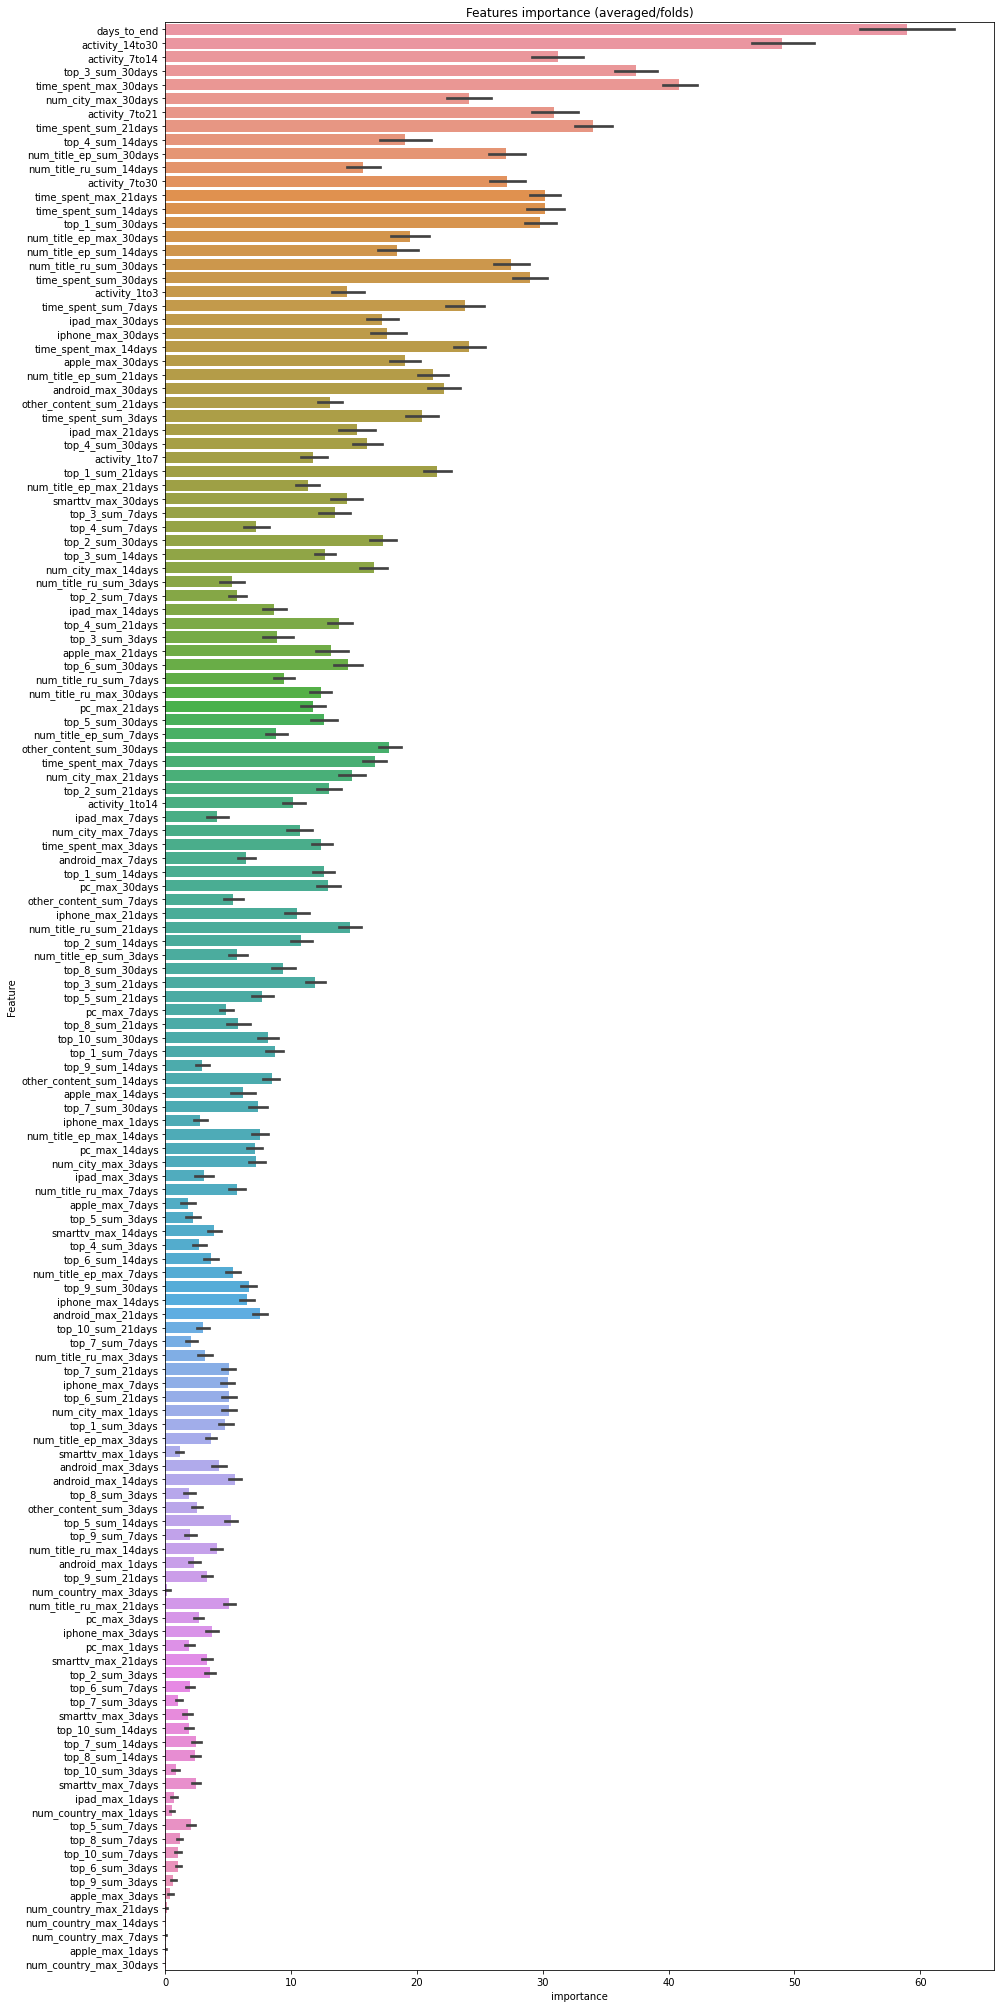

In [26]:
def plot_feature_importance(feature_importance_df):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:150].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(14,28))
    sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
    plt.title('Features importance (averaged/folds)')
    plt.tight_layout()
    plt.show()

plot_feature_importance(feature_importance_df)

In [28]:
def fill_nan_add(df):
    not_filled_emails =[]
    # Получаем список всех email, у которых имеется NaN
    nan_email = df[df['trial'].isnull()]['email'].unique().tolist()
    for i in nan_email:
        # Находим список индексов NaN
        nan_idx = df[(df['email'] == i) & (df['trial'].isnull())].index
        # Находим список индексов по этому email
        idx_list = df[df['email'] == i].index.tolist()
        # Заполняем NaN первым заполненным значением из списка индексов по email
        for idx in nan_idx:
            try:
                if idx_list[idx_list.index(idx) + 1] not in nan_idx:
                    filler_idx = idx_list[idx_list.index(idx) + 1]
                    df.loc[idx, 'trial'] = df.loc[filler_idx]['trial']
            except IndexError:
                not_filled_emails.append(i)
    return not_filled_emails, df


not_filled_emails, train_add = fill_nan_add(train_add)
print(not_filled_emails, train_add.isnull().sum().sum())
not_filled_emails, test_add = fill_nan_add(test_add)
print(not_filled_emails, test_add.isnull().sum().sum())

[] 0
[] 0


In [0]:
train_add['calday'] = pd.to_datetime(train_add['calday'])
test_add['calday'] = pd.to_datetime(test_add['calday'])

In [30]:
train_prep_test = train_prep[train_prep['email'].isin(['5e4cb090f4', '8ba752f2c5', '752a6d96f7'])][['email', 'cut_date', 'last_date', 'first_date']].sort_values(by='cut_date')
train_prep_test

,email,cut_date,last_date,first_date
34228,752a6d96f7,2019-03-29,2019-03-26 09:35:23,2018-10-28
131461,8ba752f2c5,2019-03-30,2019-03-13 09:36:59,2019-02-10
10441,752a6d96f7,2019-03-30,2019-03-26 09:35:23,2018-10-28
162739,8ba752f2c5,2019-03-31,2019-03-13 09:36:59,2019-02-10
46305,752a6d96f7,2019-03-31,2019-03-26 09:35:23,2018-10-28
76545,8ba752f2c5,2019-04-01,2019-03-13 09:36:59,2019-02-10
93084,752a6d96f7,2019-04-01,2019-04-01 20:51:29,2018-10-28
0,8ba752f2c5,2019-04-02,2019-03-13 09:36:59,2019-02-10
1,752a6d96f7,2019-04-02,2019-04-01 20:51:29,2018-10-28
35724,8ba752f2c5,2019-04-03,2019-03-13 09:36:59,2019-02-10


In [31]:
train_add[train_add['email'] == '5e4cb090f4'].sort_values(by='calday')

,action,email,trial,calday
1794,CREATE,5e4cb090f4,True,2018-12-04 11:22:14.711
2888,DELETE,5e4cb090f4,True,2018-12-07 11:52:52.314
3337,DELETE,5e4cb090f4,True,2018-12-08 15:04:52.561
3924,CREATE,5e4cb090f4,True,2018-12-09 23:24:34.346
5227,DELETE,5e4cb090f4,True,2018-12-12 23:54:52.365
6952,CREATE,5e4cb090f4,False,2018-12-18 04:59:56.575
15651,DELETE,5e4cb090f4,False,2019-01-18 05:30:17.013
24481,CREATE,5e4cb090f4,False,2019-02-20 21:00:50.860
33225,CREATE,5e4cb090f4,False,2019-03-20 14:31:05.449


In [32]:
print(train_add['calday'].max(), train_add['calday'].min())

2019-04-17 23:56:27.332000 2018-10-26 03:26:41.607000


In [33]:
print(train_prep['cut_date'].max(), train_prep['cut_date'].min())

2019-04-18 00:00:00 2019-03-29 00:00:00


In [34]:
train_add_test = train_add[train_add['email'].isin(['5e4cb090f4', '8ba752f2c5', '752a6d96f7'])].sort_values(by='calday')
train_add_test

,action,email,trial,calday
1720,DELETE,752a6d96f7,False,2018-12-04 06:42:52.652
1733,CREATE,752a6d96f7,False,2018-12-04 07:27:42.767
1794,CREATE,5e4cb090f4,True,2018-12-04 11:22:14.711
2888,DELETE,5e4cb090f4,True,2018-12-07 11:52:52.314
3337,DELETE,5e4cb090f4,True,2018-12-08 15:04:52.561
3924,CREATE,5e4cb090f4,True,2018-12-09 23:24:34.346
5227,DELETE,5e4cb090f4,True,2018-12-12 23:54:52.365
6952,CREATE,5e4cb090f4,False,2018-12-18 04:59:56.575
11178,DELETE,752a6d96f7,False,2019-01-03 19:28:16.987
11298,CREATE,752a6d96f7,False,2019-01-04 11:03:06.658


In [35]:
def modify_add_df(df):
    df['trial_both'] = 0
    df['trial_False'] = 0
    df['trial_last'] = 0
    df['trial_first'] = 0
    emails = df['email'].unique().tolist()
    for email in emails:
        trials = df[df['email'] == email]['trial'].unique().tolist()
        if len(trials) > 1:
            df.loc[df['email'] == email, 'trial_both'] = 1
        elif trials[0] == False:
            df.loc[df['email'] == email, 'trial_False'] = 1
        if trials[-1] == True:
            df.loc[df['email'] == email, 'trial_last'] = 1
        if trials[0] == True:
            df.loc[df['email'] == email, 'trial_first'] = 1
    df = df.sort_values(by='calday').drop_duplicates(subset='email', keep='last')
    df['action'] = np.where(df['action'] == 'CREATE', 1, 0)
    return df


train_add_test = modify_add_df(train_add_test)
train_add_test

,action,email,trial,calday,trial_both,trial_False,trial_last,trial_first
21559,1,8ba752f2c5,True,2019-02-10 18:55:37.353,0,0,1,1
33225,1,5e4cb090f4,False,2019-03-20 14:31:05.449,1,0,0,1
40811,0,752a6d96f7,False,2019-04-10 14:52:44.327,0,1,0,0


In [0]:
train_add = modify_add_df(train_add)
test_add = modify_add_df(test_add)

In [37]:
train_prep_test = train_prep_test.merge(train_add_test[['action','email', 'trial_both', 'trial_False', 'trial_last', 'trial_first']], on='email')
train_prep_test

,email,cut_date,last_date,first_date,action,trial_both,trial_False,trial_last,trial_first
0,752a6d96f7,2019-03-29,2019-03-26 09:35:23,2018-10-28,0,0,1,0,0
1,752a6d96f7,2019-03-30,2019-03-26 09:35:23,2018-10-28,0,0,1,0,0
2,752a6d96f7,2019-03-31,2019-03-26 09:35:23,2018-10-28,0,0,1,0,0
3,752a6d96f7,2019-04-01,2019-04-01 20:51:29,2018-10-28,0,0,1,0,0
4,752a6d96f7,2019-04-02,2019-04-01 20:51:29,2018-10-28,0,0,1,0,0
5,752a6d96f7,2019-04-03,2019-04-01 20:51:29,2018-10-28,0,0,1,0,0
6,752a6d96f7,2019-04-04,2019-04-01 20:51:29,2018-10-28,0,0,1,0,0
7,752a6d96f7,2019-04-05,2019-04-01 20:51:29,2018-10-28,0,0,1,0,0
8,752a6d96f7,2019-04-06,2019-04-01 20:51:29,2018-10-28,0,0,1,0,0
9,752a6d96f7,2019-04-07,2019-04-01 20:51:29,2018-10-28,0,0,1,0,0


In [0]:
train_prep = train_prep.merge(train_add[['action','email', 'trial_both', 'trial_False', 'trial_last', 'trial_first']], on='email')
test_prep = test_prep.merge(test_add[['action','email', 'trial_both', 'trial_False', 'trial_last', 'trial_first']], on='email') 

In [39]:
_, _, _ = lgbm_model_2(train_prep, cut_dates, threshold=0.35)

1/20----------------------For 2019-03-29 PR score: 0.82863 , ROC score: 0.81198 
2/20----------------------For 2019-03-30 PR score: 0.84811 , ROC score: 0.84097 
3/20----------------------For 2019-03-31 PR score: 0.85179 , ROC score: 0.85682 
4/20----------------------For 2019-04-01 PR score: 0.86198 , ROC score: 0.85666 
5/20----------------------For 2019-04-02 PR score: 0.85276 , ROC score: 0.85408 
6/20----------------------For 2019-04-03 PR score: 0.84313 , ROC score: 0.84432 
7/20----------------------For 2019-04-04 PR score: 0.83076 , ROC score: 0.84828 
8/20----------------------For 2019-04-05 PR score: 0.81439 , ROC score: 0.84188 
9/20----------------------For 2019-04-06 PR score: 0.78956 , ROC score: 0.82748 
10/20----------------------For 2019-04-07 PR score: 0.78247 , ROC score: 0.83018 
11/20----------------------For 2019-04-08 PR score: 0.75432 , ROC score: 0.82003 
12/20----------------------For 2019-04-09 PR score: 0.74457 , ROC score: 0.81241 
13/20--------------------

In [40]:
train_raw_test = train_raw[train_raw['email'].isin(train_raw[train_raw['utc_offset'].isnull()]['email'].unique().tolist()[:3])]
train_raw_test['email'].unique().tolist()

['a939aa6916', '8881ecd18b', 'd1bd2d877f']

In [41]:
train_raw_test.isnull().sum()

email               0
title_ep            0
title_ru            0
calday              0
dt1                 0
timelength          0
device              0
country_iso_code    7
city_iso_code       7
utc_offset          7
dtype: int64

In [42]:
def fill_nan_raw(df):
    not_filled_emails =[]
    # Получаем список всех email, у которых имеется NaN
    nan_email = df[df['utc_offset'].isnull()]['email'].unique().tolist()
    for i in nan_email:
        # Находим список индексов NaN
        nan_idx = df[(df['email'] == i) & (df['utc_offset'].isnull())].index
        # Находим список индексов по этому email
        idx_list = df[df['email'] == i].index.tolist()
        # Найдем не NaN элементы в idx_list
        not_nan_idx_list = list(set(idx_list) - set(nan_idx))
        mean_offset = df.loc[not_nan_idx_list]['utc_offset'].mean()
        df.loc[nan_idx, 'utc_offset'] = mean_offset

fill_nan_raw(train_raw_test)
train_raw_test.isnull().sum()

email               0
title_ep            0
title_ru            0
calday              0
dt1                 0
timelength          0
device              0
country_iso_code    7
city_iso_code       7
utc_offset          0
dtype: int64

In [0]:
fill_nan_raw(train_raw)
fill_nan_raw(test_raw)

In [44]:
print(train_raw.isnull().sum())
print()
print(test_raw.isnull().sum())

email                   0
title_ep                0
title_ru                0
calday                  0
dt1                     0
timelength              0
device                  0
country_iso_code      648
city_iso_code       29927
utc_offset              0
dtype: int64

email                   0
title_ep                0
title_ru                0
calday                  0
dt1                     0
timelength              0
device                  0
country_iso_code      545
city_iso_code       11924
utc_offset              0
dtype: int64


In [45]:
train_utc = train_raw[['email', 'utc_offset']].groupby('email').describe().fillna(0)
train_utc.columns = ['utc_count', 'utc_mean', 'utc_std', 'min', '25', '50', '75', 'max']
train_utc

,utc_count,utc_mean,utc_std,min,25,50,75,max
email,,,,,,,,
00012a0ea1,122.0,7.000000,0.000000,7.0,7.0,7.0,7.0,7.0
0002d59824,441.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0
001014e9a8,49.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0
0012e60bcb,6.0,7.000000,0.000000,7.0,7.0,7.0,7.0,7.0
001673d7cf,28.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...
ffec69dd98,111.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0
ffecd9dfba,48.0,3.979167,0.144338,3.0,4.0,4.0,4.0,4.0
ffeeb121bd,1.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0


In [46]:
test_utc = test_raw[['email', 'utc_offset']].groupby('email').describe().fillna(0)
test_utc.columns = ['utc_count', 'utc_mean', 'utc_std', 'min', '25', '50', '75', 'max']
test_utc

,utc_count,utc_mean,utc_std,min,25,50,75,max
email,,,,,,,,
000568a584,28.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0
0009f0da8c,8.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0
00106be5a4,48.0,4.000000,0.000000,4.0,4.0,4.0,4.0,4.0
0012481017,151.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0
001aac3e5d,39.0,2.948718,0.223456,2.0,3.0,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...
ffe0462fd3,5.0,8.600000,3.130495,3.0,10.0,10.0,10.0,10.0
ffedb6fccb,28.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0
fff73ffe04,114.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0


In [0]:
train_prep = train_prep.merge(train_utc, on='email')
test_prep = test_prep.merge(test_utc, on='email')

In [48]:
_, _, _ = lgbm_model_2(train_prep, cut_dates, threshold=0.35)

1/20----------------------For 2019-03-29 PR score: 0.83389 , ROC score: 0.81280 
2/20----------------------For 2019-03-30 PR score: 0.85177 , ROC score: 0.84149 
3/20----------------------For 2019-03-31 PR score: 0.85755 , ROC score: 0.85736 
4/20----------------------For 2019-04-01 PR score: 0.86251 , ROC score: 0.85677 
5/20----------------------For 2019-04-02 PR score: 0.85688 , ROC score: 0.85464 
6/20----------------------For 2019-04-03 PR score: 0.84189 , ROC score: 0.84422 
7/20----------------------For 2019-04-04 PR score: 0.83210 , ROC score: 0.84860 
8/20----------------------For 2019-04-05 PR score: 0.81464 , ROC score: 0.84219 
9/20----------------------For 2019-04-06 PR score: 0.79141 , ROC score: 0.82800 
10/20----------------------For 2019-04-07 PR score: 0.78431 , ROC score: 0.83068 
11/20----------------------For 2019-04-08 PR score: 0.75773 , ROC score: 0.82123 
12/20----------------------For 2019-04-09 PR score: 0.74665 , ROC score: 0.81322 
13/20--------------------

In [49]:
train_prep.head()

,cut_date,days_to_end,email,first_date,last_date,num_country_max_1days,num_city_max_1days,android_max_1days,smarttv_max_1days,iphone_max_1days,ipad_max_1days,apple_max_1days,pc_max_1days,time_spent_sum_3days,time_spent_max_3days,num_title_ep_sum_3days,num_title_ep_max_3days,num_title_ru_sum_3days,num_title_ru_max_3days,num_country_max_3days,num_city_max_3days,other_content_sum_3days,top_1_sum_3days,top_2_sum_3days,top_3_sum_3days,top_4_sum_3days,top_5_sum_3days,top_6_sum_3days,top_7_sum_3days,top_8_sum_3days,top_9_sum_3days,top_10_sum_3days,android_max_3days,smarttv_max_3days,iphone_max_3days,ipad_max_3days,apple_max_3days,pc_max_3days,time_spent_sum_7days,time_spent_max_7days,num_title_ep_sum_7days,num_title_ep_max_7days,num_title_ru_sum_7days,num_title_ru_max_7days,num_country_max_7days,num_city_max_7days,other_content_sum_7days,top_1_sum_7days,top_2_sum_7days,top_3_sum_7days,top_4_sum_7days,top_5_sum_7days,top_6_sum_7days,top_7_sum_7days,top_8_sum_7days,top_9_sum_7days,top_10_sum_7days,android_max_7days,smarttv_max_7days,iphone_max_7days,ipad_max_7days,apple_max_7days,pc_max_7days,time_spent_sum_14days,time_spent_max_14days,num_title_ep_sum_14days,num_title_ep_max_14days,num_title_ru_sum_14days,num_title_ru_max_14days,num_country_max_14days,num_city_max_14days,other_content_sum_14days,top_1_sum_14days,top_2_sum_14days,top_3_sum_14days,top_4_sum_14days,top_5_sum_14days,top_6_sum_14days,top_7_sum_14days,top_8_sum_14days,top_9_sum_14days,top_10_sum_14days,android_max_14days,smarttv_max_14days,iphone_max_14days,ipad_max_14days,apple_max_14days,pc_max_14days,time_spent_sum_21days,time_spent_max_21days,num_title_ep_sum_21days,num_title_ep_max_21days,num_title_ru_sum_21days,num_title_ru_max_21days,num_country_max_21days,num_city_max_21days,other_content_sum_21days,top_1_sum_21days,top_2_sum_21days,top_3_sum_21days,top_4_sum_21days,top_5_sum_21days,top_6_sum_21days,top_7_sum_21days,top_8_sum_21days,top_9_sum_21days,top_10_sum_21days,android_max_21days,smarttv_max_21days,iphone_max_21days,ipad_max_21days,apple_max_21days,pc_max_21days,time_spent_sum_30days,time_spent_max_30days,num_title_ep_sum_30days,num_title_ep_max_30days,num_title_ru_sum_30days,num_title_ru_max_30days,num_country_max_30days,num_city_max_30days,other_content_sum_30days,top_1_sum_30days,top_2_sum_30days,top_3_sum_30days,top_4_sum_30days,top_5_sum_30days,top_6_sum_30days,top_7_sum_30days,top_8_sum_30days,top_9_sum_30days,top_10_sum_30days,android_max_30days,smarttv_max_30days,iphone_max_30days,ipad_max_30days,apple_max_30days,pc_max_30days,activity_1to3,activity_1to7,activity_1to14,activity_7to14,activity_7to21,activity_7to30,activity_14to30,label,action,trial_both,trial_False,trial_last,trial_first,utc_count,utc_mean,utc_std,min,25,50,75,max
0,2019-04-02,11,8ba752f2c5,2019-02-10,2019-03-13 09:36:59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4367.0,4367.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,59073.0,25595.0,10.0,4.0,10.0,4.0,1.0,20.0,6.0,17.0,20.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,1,49.0,3.0,0.0,3.0,3.0,3.0,3.0,3.0
1,2019-04-11,2,8ba752f2c5,2019-02-10,2019-03-13 09:36:59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4367.0,4367.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [50]:
train_prep[['email', 'label']].groupby('email').mean()['label'].value_counts()

0.000000    14443
1.000000     5519
0.500000       10
0.666667        5
0.400000        5
0.750000        5
0.250000        5
0.200000        3
0.333333        2
0.800000        2
0.066667        1
Name: label, dtype: int64

In [51]:
data = train_prep.merge(train_prep[['email', 'label']].groupby('email')['label'].mean(), on='email')
data.label_y.value_counts()
multilabel_emails = data[(data['label_y'] > 0) & (data['label_y'] < 1)].sort_values(by=['email', 'cut_date'])['email'].unique().tolist()
train_prep[train_prep['email'].isin(multilabel_emails)].groupby('email')['label'].mean().value_counts()

0.500000    10
0.666667     5
0.400000     5
0.750000     5
0.250000     5
0.200000     3
0.800000     2
0.333333     2
0.066667     1
Name: label, dtype: int64

In [52]:
train_prep = train_prep.drop(train_prep[train_prep['email'].isin(multilabel_emails)].index)
train_prep[['email', 'label']].groupby('email')['label'].mean().value_counts()

0.0    14443
1.0     5519
Name: label, dtype: int64

In [53]:
_, predictions, _ = lgbm_model_2(train_prep, cut_dates, threshold=0.35)

1/20----------------------For 2019-03-29 PR score: 0.83052 , ROC score: 0.81136 
2/20----------------------For 2019-03-30 PR score: 0.85400 , ROC score: 0.84138 
3/20----------------------For 2019-03-31 PR score: 0.85723 , ROC score: 0.85725 
4/20----------------------For 2019-04-01 PR score: 0.86395 , ROC score: 0.85726 
5/20----------------------For 2019-04-02 PR score: 0.85456 , ROC score: 0.85476 
6/20----------------------For 2019-04-03 PR score: 0.83962 , ROC score: 0.84415 
7/20----------------------For 2019-04-04 PR score: 0.83372 , ROC score: 0.84842 
8/20----------------------For 2019-04-05 PR score: 0.81146 , ROC score: 0.84160 
9/20----------------------For 2019-04-06 PR score: 0.79513 , ROC score: 0.82907 
10/20----------------------For 2019-04-07 PR score: 0.78436 , ROC score: 0.83120 
11/20----------------------For 2019-04-08 PR score: 0.76208 , ROC score: 0.82253 
12/20----------------------For 2019-04-09 PR score: 0.73993 , ROC score: 0.81232 
13/20--------------------

In [54]:
dates = cut_dates[:6] + [cut_dates[-1]]
dates

[datetime.date(2019, 3, 29),
 datetime.date(2019, 3, 30),
 datetime.date(2019, 3, 31),
 datetime.date(2019, 4, 1),
 datetime.date(2019, 4, 2),
 datetime.date(2019, 4, 3),
 datetime.date(2019, 4, 18)]

In [55]:
_, predictions, _ = lgbm_model_2(train_prep, dates, threshold=0.35)

1/6----------------------For 2019-03-29 PR score: 0.83052 , ROC score: 0.81136 
2/6----------------------For 2019-03-30 PR score: 0.85400 , ROC score: 0.84138 
3/6----------------------For 2019-03-31 PR score: 0.85723 , ROC score: 0.85725 
4/6----------------------For 2019-04-01 PR score: 0.86395 , ROC score: 0.85726 
5/6----------------------For 2019-04-02 PR score: 0.85456 , ROC score: 0.85476 
6/6----------------------For 2019-04-03 PR score: 0.83962 , ROC score: 0.84415 
PR score last day: 0.27159 , ROC score: 0.50517 
Confusion matrix for last date:
[[7544    5]
 [2418   13]]


In [56]:
columns = train_prep.drop('label', axis=1).columns.tolist()[5:]
date = cut_dates[-1]
n = len(columns)
for i in range(n):
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.hist(x=columns[i], data=train_prep[train_prep['cut_date'] == date])
    plt.title('TRAIN ' + str(columns[i]))

    plt.subplot(1, 2, 2)
    plt.hist(x=columns[i], data=test_prep)
    plt.title('TEST ' + str(columns[i]))
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [57]:
train_prep.head(2)

,cut_date,days_to_end,email,first_date,last_date,num_country_max_1days,num_city_max_1days,android_max_1days,smarttv_max_1days,iphone_max_1days,ipad_max_1days,apple_max_1days,pc_max_1days,time_spent_sum_3days,time_spent_max_3days,num_title_ep_sum_3days,num_title_ep_max_3days,num_title_ru_sum_3days,num_title_ru_max_3days,num_country_max_3days,num_city_max_3days,other_content_sum_3days,top_1_sum_3days,top_2_sum_3days,top_3_sum_3days,top_4_sum_3days,top_5_sum_3days,top_6_sum_3days,top_7_sum_3days,top_8_sum_3days,top_9_sum_3days,top_10_sum_3days,android_max_3days,smarttv_max_3days,iphone_max_3days,ipad_max_3days,apple_max_3days,pc_max_3days,time_spent_sum_7days,time_spent_max_7days,num_title_ep_sum_7days,num_title_ep_max_7days,num_title_ru_sum_7days,num_title_ru_max_7days,num_country_max_7days,num_city_max_7days,other_content_sum_7days,top_1_sum_7days,top_2_sum_7days,top_3_sum_7days,top_4_sum_7days,top_5_sum_7days,top_6_sum_7days,top_7_sum_7days,top_8_sum_7days,top_9_sum_7days,top_10_sum_7days,android_max_7days,smarttv_max_7days,iphone_max_7days,ipad_max_7days,apple_max_7days,pc_max_7days,time_spent_sum_14days,time_spent_max_14days,num_title_ep_sum_14days,num_title_ep_max_14days,num_title_ru_sum_14days,num_title_ru_max_14days,num_country_max_14days,num_city_max_14days,other_content_sum_14days,top_1_sum_14days,top_2_sum_14days,top_3_sum_14days,top_4_sum_14days,top_5_sum_14days,top_6_sum_14days,top_7_sum_14days,top_8_sum_14days,top_9_sum_14days,top_10_sum_14days,android_max_14days,smarttv_max_14days,iphone_max_14days,ipad_max_14days,apple_max_14days,pc_max_14days,time_spent_sum_21days,time_spent_max_21days,num_title_ep_sum_21days,num_title_ep_max_21days,num_title_ru_sum_21days,num_title_ru_max_21days,num_country_max_21days,num_city_max_21days,other_content_sum_21days,top_1_sum_21days,top_2_sum_21days,top_3_sum_21days,top_4_sum_21days,top_5_sum_21days,top_6_sum_21days,top_7_sum_21days,top_8_sum_21days,top_9_sum_21days,top_10_sum_21days,android_max_21days,smarttv_max_21days,iphone_max_21days,ipad_max_21days,apple_max_21days,pc_max_21days,time_spent_sum_30days,time_spent_max_30days,num_title_ep_sum_30days,num_title_ep_max_30days,num_title_ru_sum_30days,num_title_ru_max_30days,num_country_max_30days,num_city_max_30days,other_content_sum_30days,top_1_sum_30days,top_2_sum_30days,top_3_sum_30days,top_4_sum_30days,top_5_sum_30days,top_6_sum_30days,top_7_sum_30days,top_8_sum_30days,top_9_sum_30days,top_10_sum_30days,android_max_30days,smarttv_max_30days,iphone_max_30days,ipad_max_30days,apple_max_30days,pc_max_30days,activity_1to3,activity_1to7,activity_1to14,activity_7to14,activity_7to21,activity_7to30,activity_14to30,label,action,trial_both,trial_False,trial_last,trial_first,utc_count,utc_mean,utc_std,min,25,50,75,max
0,2019-04-02,11,8ba752f2c5,2019-02-10,2019-03-13 09:36:59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4367.0,4367.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,59073.0,25595.0,10.0,4.0,10.0,4.0,1.0,20.0,6.0,17.0,20.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1,1,49.0,3.0,0.0,3.0,3.0,3.0,3.0,3.0
1,2019-04-11,2,8ba752f2c5,2019-02-10,2019-03-13 09:36:59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4367.0,4367.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [0]:
train_prep['days_in'] = train_prep['cut_date'] - train_prep['first_date']
train_prep['days_from_last'] = train_prep['cut_date'] - train_prep['last_date']
train_prep['days_in'] = train_prep['days_in'].apply(lambda x: x.days)
train_prep['days_from_last'] = train_prep['days_from_last'].apply(lambda x: x.days)

In [0]:
test_prep['days_in'] = test_prep['cut_date'] - test_prep['first_date']
test_prep['days_from_last'] = test_prep['cut_date'] - test_prep['last_date']
test_prep['days_in'] = test_prep['days_in'].apply(lambda x: x.days)
test_prep['days_from_last'] = test_prep['days_from_last'].apply(lambda x: x.days)

In [60]:
_, preds, _ = lgbm_model_2(train_prep, cut_dates, threshold=0.35)

1/20----------------------For 2019-03-29 PR score: 0.83307 , ROC score: 0.81147 
2/20----------------------For 2019-03-30 PR score: 0.85621 , ROC score: 0.84223 
3/20----------------------For 2019-03-31 PR score: 0.86172 , ROC score: 0.85783 
4/20----------------------For 2019-04-01 PR score: 0.86425 , ROC score: 0.85764 
5/20----------------------For 2019-04-02 PR score: 0.85614 , ROC score: 0.85525 
6/20----------------------For 2019-04-03 PR score: 0.84562 , ROC score: 0.84496 
7/20----------------------For 2019-04-04 PR score: 0.83685 , ROC score: 0.84892 
8/20----------------------For 2019-04-05 PR score: 0.81590 , ROC score: 0.84197 
9/20----------------------For 2019-04-06 PR score: 0.79830 , ROC score: 0.82971 
10/20----------------------For 2019-04-07 PR score: 0.78280 , ROC score: 0.83078 
11/20----------------------For 2019-04-08 PR score: 0.76764 , ROC score: 0.82344 
12/20----------------------For 2019-04-09 PR score: 0.74437 , ROC score: 0.81356 
13/20--------------------

In [61]:
def drop_outliers(df, col):
    q_hi  = df[col].quantile(0.99)

    df_filtered = df[df[col] < q_hi]
    return df_filtered

cols_idx = train_prep.nunique() > 1000
cols_idx = [idx for idx, col in enumerate(cols_idx) if col == True]
cols_idx = cols_idx[2:]
cols = train_prep.columns.tolist()
cols = [cols[idx] for idx in cols_idx]
df = train_prep.copy()
for col in cols:
    df = drop_outliers(df, col)
df

,cut_date,days_to_end,email,first_date,last_date,num_country_max_1days,num_city_max_1days,android_max_1days,smarttv_max_1days,iphone_max_1days,ipad_max_1days,apple_max_1days,pc_max_1days,time_spent_sum_3days,time_spent_max_3days,num_title_ep_sum_3days,num_title_ep_max_3days,num_title_ru_sum_3days,num_title_ru_max_3days,num_country_max_3days,num_city_max_3days,other_content_sum_3days,top_1_sum_3days,top_2_sum_3days,top_3_sum_3days,top_4_sum_3days,top_5_sum_3days,top_6_sum_3days,top_7_sum_3days,top_8_sum_3days,top_9_sum_3days,top_10_sum_3days,android_max_3days,smarttv_max_3days,iphone_max_3days,ipad_max_3days,apple_max_3days,pc_max_3days,time_spent_sum_7days,time_spent_max_7days,num_title_ep_sum_7days,num_title_ep_max_7days,num_title_ru_sum_7days,num_title_ru_max_7days,num_country_max_7days,num_city_max_7days,other_content_sum_7days,top_1_sum_7days,top_2_sum_7days,top_3_sum_7days,top_4_sum_7days,top_5_sum_7days,top_6_sum_7days,top_7_sum_7days,top_8_sum_7days,top_9_sum_7days,top_10_sum_7days,android_max_7days,smarttv_max_7days,iphone_max_7days,ipad_max_7days,apple_max_7days,pc_max_7days,time_spent_sum_14days,time_spent_max_14days,num_title_ep_sum_14days,num_title_ep_max_14days,num_title_ru_sum_14days,num_title_ru_max_14days,num_country_max_14days,num_city_max_14days,other_content_sum_14days,top_1_sum_14days,top_2_sum_14days,top_3_sum_14days,top_4_sum_14days,top_5_sum_14days,top_6_sum_14days,top_7_sum_14days,top_8_sum_14days,top_9_sum_14days,top_10_sum_14days,android_max_14days,smarttv_max_14days,iphone_max_14days,ipad_max_14days,apple_max_14days,pc_max_14days,time_spent_sum_21days,time_spent_max_21days,num_title_ep_sum_21days,num_title_ep_max_21days,num_title_ru_sum_21days,num_title_ru_max_21days,num_country_max_21days,num_city_max_21days,other_content_sum_21days,top_1_sum_21days,top_2_sum_21days,top_3_sum_21days,top_4_sum_21days,top_5_sum_21days,top_6_sum_21days,top_7_sum_21days,top_8_sum_21days,top_9_sum_21days,top_10_sum_21days,android_max_21days,smarttv_max_21days,iphone_max_21days,ipad_max_21days,apple_max_21days,pc_max_21days,time_spent_sum_30days,time_spent_max_30days,num_title_ep_sum_30days,num_title_ep_max_30days,num_title_ru_sum_30days,num_title_ru_max_30days,num_country_max_30days,num_city_max_30days,other_content_sum_30days,top_1_sum_30days,top_2_sum_30days,top_3_sum_30days,top_4_sum_30days,top_5_sum_30days,top_6_sum_30days,top_7_sum_30days,top_8_sum_30days,top_9_sum_30days,top_10_sum_30days,android_max_30days,smarttv_max_30days,iphone_max_30days,ipad_max_30days,apple_max_30days,pc_max_30days,activity_1to3,activity_1to7,activity_1to14,activity_7to14,activity_7to21,activity_7to30,activity_14to30,label,action,trial_both,trial_False,trial_last,trial_first,utc_count,utc_mean,utc_std,min,25,50,75,max,days_in,days_from_last
0,2019-04-02,11,8ba752f2c5,2019-02-10,2019-03-13 09:36:59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4367.0,4367.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,59073.0,25595.0,10.0,4.0,10.0,4.0,1.0,20.0,6.0,17.0,20.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1,0,0,1,1,49.0,3.0,0.0,3.0,3.0,3.0,3.0,3.0,51,19
1,2019-04-11,2,8ba752f2c5,2019-02-10,2019-03-13 09:36:59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4367.0,4367.0,2.0,2.0,2

In [62]:
_, preds, feature_importance_df = lgbm_model_2(df, cut_dates, threshold=0.35)

1/20----------------------For 2019-03-29 PR score: 0.82807 , ROC score: 0.80431 
2/20----------------------For 2019-03-30 PR score: 0.85854 , ROC score: 0.83886 
3/20----------------------For 2019-03-31 PR score: 0.86455 , ROC score: 0.85388 
4/20----------------------For 2019-04-01 PR score: 0.87263 , ROC score: 0.85839 
5/20----------------------For 2019-04-02 PR score: 0.85844 , ROC score: 0.85424 
6/20----------------------For 2019-04-03 PR score: 0.84264 , ROC score: 0.84130 
7/20----------------------For 2019-04-04 PR score: 0.84524 , ROC score: 0.84461 
8/20----------------------For 2019-04-05 PR score: 0.82517 , ROC score: 0.84262 
9/20----------------------For 2019-04-06 PR score: 0.79984 , ROC score: 0.82859 
10/20----------------------For 2019-04-07 PR score: 0.79363 , ROC score: 0.82587 
11/20----------------------For 2019-04-08 PR score: 0.77064 , ROC score: 0.82074 
12/20----------------------For 2019-04-09 PR score: 0.75956 , ROC score: 0.81742 
13/20--------------------

In [63]:
fi = feature_importance_df[["Feature", "importance"]].groupby("Feature").mean().sort_values(by="importance", ascending=False)
important_cols = list(fi[fi['importance'] > 5].index) + ['cut_date', 'email', 'first_date', 'last_date']
important_cols

['days_in',
 'days_to_end',
 'utc_count',
 'action',
 'activity_14to30',
 'days_from_last',
 'time_spent_max_30days',
 'num_city_max_30days',
 'time_spent_sum_30days',
 'time_spent_sum_21days',
 'activity_7to14',
 'time_spent_sum_14days',
 'time_spent_max_21days',
 'trial_last',
 'iphone_max_30days',
 'activity_7to21',
 'top_1_sum_30days',
 'activity_7to30',
 'time_spent_max_14days',
 'time_spent_sum_7days',
 'other_content_sum_30days',
 'time_spent_max_7days',
 'num_title_ru_sum_30days',
 'top_2_sum_30days',
 'top_3_sum_30days',
 'num_title_ep_sum_30days',
 'num_title_ep_sum_21days',
 'top_1_sum_21days',
 'android_max_30days',
 'top_4_sum_30days',
 'utc_mean',
 'top_3_sum_21days',
 'top_4_sum_14days',
 'iphone_max_21days',
 'pc_max_30days',
 'num_title_ru_sum_21days',
 'num_city_max_21days',
 'top_2_sum_21days',
 'num_title_ru_sum_14days',
 'other_content_sum_21days',
 'top_6_sum_30days',
 'iphone_max_14days',
 'num_city_max_14days',
 'time_spent_max_3days',
 'android_max_21days',
 't

In [64]:
_, preds, _ = lgbm_model_2(train_prep[important_cols + ['label']], cut_dates, threshold=0.35)

1/20----------------------For 2019-03-29 PR score: 0.83231 , ROC score: 0.81115 
2/20----------------------For 2019-03-30 PR score: 0.85559 , ROC score: 0.84200 
3/20----------------------For 2019-03-31 PR score: 0.86130 , ROC score: 0.85759 
4/20----------------------For 2019-04-01 PR score: 0.86678 , ROC score: 0.85778 
5/20----------------------For 2019-04-02 PR score: 0.85360 , ROC score: 0.85520 
6/20----------------------For 2019-04-03 PR score: 0.84453 , ROC score: 0.84463 
7/20----------------------For 2019-04-04 PR score: 0.83730 , ROC score: 0.84887 
8/20----------------------For 2019-04-05 PR score: 0.81809 , ROC score: 0.84226 
9/20----------------------For 2019-04-06 PR score: 0.79864 , ROC score: 0.82958 
10/20----------------------For 2019-04-07 PR score: 0.78422 , ROC score: 0.83090 
11/20----------------------For 2019-04-08 PR score: 0.76885 , ROC score: 0.82374 
12/20----------------------For 2019-04-09 PR score: 0.74607 , ROC score: 0.81405 
13/20--------------------

In [65]:
_, preds, _ = lgbm_model_2(train_prep[important_cols + ['label']], cut_dates, test_prep[important_cols], threshold=0.35)

1/21----------------------For 2019-03-29 PR score: 0.83231 , ROC score: 0.81115 
2/21----------------------For 2019-03-30 PR score: 0.85559 , ROC score: 0.84200 
3/21----------------------For 2019-03-31 PR score: 0.86130 , ROC score: 0.85759 
4/21----------------------For 2019-04-01 PR score: 0.86678 , ROC score: 0.85778 
5/21----------------------For 2019-04-02 PR score: 0.85360 , ROC score: 0.85520 
6/21----------------------For 2019-04-03 PR score: 0.84453 , ROC score: 0.84463 
7/21----------------------For 2019-04-04 PR score: 0.83730 , ROC score: 0.84887 
8/21----------------------For 2019-04-05 PR score: 0.81809 , ROC score: 0.84226 
9/21----------------------For 2019-04-06 PR score: 0.79864 , ROC score: 0.82958 
10/21----------------------For 2019-04-07 PR score: 0.78422 , ROC score: 0.83090 
11/21----------------------For 2019-04-08 PR score: 0.76885 , ROC score: 0.82374 
12/21----------------------For 2019-04-09 PR score: 0.74607 , ROC score: 0.81405 
13/21--------------------

In [66]:
test_prep['cut_date'].unique()

array(['2019-05-03T00:00:00.000000000'], dtype='datetime64[ns]')

In [71]:
for i in range(3, 7):
    _, _, _ = lgbm_model_2(train_prep[important_cols + ['label']], cut_dates[:i], threshold=0.35)

1/2----------------------For 2019-03-29 PR score: 0.83231 , ROC score: 0.81115 
2/2----------------------For 2019-03-30 PR score: 0.85559 , ROC score: 0.84200 
PR score last day: 0.96140 , ROC score: 0.98775 
Confusion matrix for last date:
[[5511  297]
 [  50 1887]]
1/3----------------------For 2019-03-29 PR score: 0.83231 , ROC score: 0.81115 
2/3----------------------For 2019-03-30 PR score: 0.85559 , ROC score: 0.84200 
3/3----------------------For 2019-03-31 PR score: 0.86130 , ROC score: 0.85759 
PR score last day: 0.95983 , ROC score: 0.98719 
Confusion matrix for last date:
[[4948  317]
 [  21 1825]]
1/4----------------------For 2019-03-29 PR score: 0.83231 , ROC score: 0.81115 
2/4----------------------For 2019-03-30 PR score: 0.85559 , ROC score: 0.84200 
3/4----------------------For 2019-03-31 PR score: 0.86130 , ROC score: 0.85759 
4/4----------------------For 2019-04-01 PR score: 0.86678 , ROC score: 0.85778 
PR score last day: 0.94874 , ROC score: 0.97793 
Confusion matri

In [72]:
_, preds, _ = lgbm_model_2(train_prep[important_cols + ['label']], cut_dates[:3], test_prep[important_cols], threshold=0.35)

1/3----------------------For 2019-03-29 PR score: 0.83231 , ROC score: 0.81115 
2/3----------------------For 2019-03-30 PR score: 0.85559 , ROC score: 0.84200 
3/3----------------------For 2019-03-31 PR score: 0.86130 , ROC score: 0.85759 
Confusion matrix for last date:


In [0]:
def make_submission(predictions, test_df):
    sub_df = test_df.set_index('email')
    sub_df['submission'] = predictions
    sub_df['submission'].to_csv('/content/gdrive/My Drive/test_task/umatech/submission.csv')

In [0]:
make_submission(preds, test_prep)